In [ ]:
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [ ]:
import pickle
from typing import Tuple

import diffrax
import equinox as eqx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import optax
import scipy.io
from jaxtyping import Array, PyTree, Scalar
from tqdm.auto import tqdm as tq

import optimal_control.constraints as constraints
import optimal_control.controls as controls
import optimal_control.environments.examples as examples
import optimal_control.nn as nn
import optimal_control.solvers as solvers
import optimal_control.trainers as trainers
from optimal_control.environments.examples.fibrosis2 import (
    FibrosisEnvironment,
    FibrosisState,
)
from optimal_control.solvers.base import build_control

In [ ]:
a4_inches = (8.3, 11.7)
plot_full_width = a4_inches[0]
plot_half_width = a4_inches[0] / 2
plot_third_width = a4_inches[0] / 3
plot_quarter_width = a4_inches[0] / 4

result_base_dir = "../thesis-results/intro"

plot_styles = ["seaborn-v0_8-paper", "seaborn-v0_8-talk"]
plot_style_names = ["", "_talk"]

plot_shrink_factor = 0.9

plt.style.use(plot_styles[0])

# Plotting functions

In [ ]:
def show(save_postfix: str, save_prefix: str = None):
    if save_prefix is not None:
        plt.savefig(result_base_dir + save_prefix + save_postfix + ".png", bbox_inches="tight")
        plt.savefig(result_base_dir + save_prefix + save_postfix + ".svg", bbox_inches="tight")

    plt.show()

def styles(plot_fn):
    for style, name in zip(plot_styles, plot_style_names):
        with plt.style.context(style):
            plot_fn(name)

In [ ]:
separatrix_array = scipy.io.loadmat("../data/Separatrix_array_F06_M07.mat")

separatrix_x = np.logspace(
    separatrix_array["lims_F"][0, 0],
    separatrix_array["lims_F"][0, 1],
    separatrix_array["tsteps"][0, 0],
)

separatrix_y = np.logspace(
    separatrix_array["lims_M"][0, 0],
    separatrix_array["lims_M"][0, 1],
    separatrix_array["tsteps"][0, 0],
)

def plot_separatrix(ax):
    ax.set_xlabel("F")
    ax.set_ylabel("M")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.pcolormesh(separatrix_x, separatrix_y, 1 - separatrix_array["S"], cmap="Greys", vmin=0.0, vmax=3.0)

In [ ]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def colorline(
    x,
    y,
    z=None,
    cmap=plt.get_cmap("copper"),
    norm=plt.Normalize(0.0, 1.0),
    linewidth=3,
    alpha=1.0,
):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(
        segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha
    )

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

# Generate trajectories

In [ ]:
environment = FibrosisEnvironment()
environment_state = environment.init()

In [ ]:
key = jax.random.PRNGKey(1234)


def reward_fn(solution: diffrax.Solution) -> Scalar:
    return solution.ys[-1, -1]
    # return -jnp.mean(jnp.log(jnp.clip(solution.ys[..., :2], a_min=1e2)))


interp_control = controls.InterpolationCurveControl(
    nn.InterpolationCurve(
        method="linear",
        t_start=0.0,
        t_end=200.0,
        steps=201,
        channels=2,
    )
)

key, subkey = jax.random.split(key)
implicit_control = controls.ImplicitTemporalControl(
    implicit_fn=nn.Siren(
        in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=200.0,
    to_curve=True,
    curve_interpolation="linear",
    curve_steps=201,
)

key, subkey = jax.random.split(key)
implicit_step_control = controls.ImplicitTemporalControl(
    implicit_fn=nn.Siren(
        in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=200.0,
    to_curve=True,
    curve_interpolation="step",
    curve_steps=10,
)

solver = solvers.DirectSolver(
    optimizer=optax.adam(learning_rate=1e-3), ignore_nans=False
)


integrate_kwargs = dict(
    max_steps=10000,
    throw=True,
    stepsize_controller=diffrax.PIDController(
        rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
    ),
)

integrate_kwargs_no_dtmax = dict(
    max_steps=10000,
    throw=True,
    stepsize_controller=diffrax.PIDController(
        rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0
    ),
)

In [ ]:
def solve(
    control: controls.AbstractControl, constraint_chain: constraints.ConstraintChain
) -> Tuple[Scalar, controls.AbstractControl]:
    optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
        num_train_steps=1024 * 4,
        environment=environment,
        reward_fn=reward_fn,
        constraint_chain=constraint_chain,
        solver=solver,
        control=control,
        key=key,
        pbar_interval=8,
        integrate_kwargs=integrate_kwargs,
    )

    return optimized_reward, optimized_control

def solve_no_dtmax(
    control: controls.AbstractControl, constraint_chain: constraints.ConstraintChain
) -> Tuple[Scalar, controls.AbstractControl]:
    optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
        num_train_steps=1024 * 4,
        environment=environment,
        reward_fn=reward_fn,
        constraint_chain=constraint_chain,
        solver=solver,
        control=control,
        key=key,
        pbar_interval=8,
        integrate_kwargs=integrate_kwargs_no_dtmax,
    )

    return optimized_reward, optimized_control

def evaluate(
    control: controls.AbstractControl, constraint_chain: constraints.ConstraintChain
):
    constrained_control = build_control(control, constraint_chain)[0]

    ts = jnp.linspace(0.0, 200.0, 201)
    cs = jax.vmap(constrained_control)(ts)

    solution = environment.integrate(
        constrained_control, environment_state, None, saveat=diffrax.SaveAt(ts=ts)
    )

    return solution, cs, constrained_control

In [ ]:
# Generate trajectories with different control curves 

constraint_chain = constraints.ConstraintChain(
    transformations=[
        constraints.NonNegativeConstantIntegralConstraint(
            target=jnp.asarray([0.1]),
            constrain_sum=True,
        )
    ]
)

proj_constraint_chain = constraints.ConstraintChain(
    projections=[
        constraints.NonNegativeConstantIntegralConstraint(
            target=jnp.asarray([0.1]),
            constrain_sum=True,
        )
    ]
)

interp_optim_reward, interp_optim_control = solve(interp_control, constraint_chain)
implicit_optim_reward, implicit_optim_control = solve(implicit_control, constraint_chain)
implicit_step_optim_reward, implicit_step_optim_control = solve(implicit_step_control, constraint_chain)
proj_interp_optim_reward, proj_interp_optim_control = solve(interp_control, proj_constraint_chain)

In [ ]:
# Prepare the RNG, with a fixed seed for reproducibility
key = jax.random.PRNGKey(1234)

# Load an environment (here, the premade environment for the fibrosis model)
environment = examples.FibrosisEnvironment()

# Define a control
control = controls.InterpolationCurveControl(
    nn.InterpolationCurve(
        method="linear",
        t_start=0.0,
        t_end=200.0,
        steps=201,
        channels=2,
    )
)

# Define a chain of constraints
constraint_chain = constraints.ConstraintChain(
    projections=[
        constraints.NonNegativeConstantIntegralConstraint(
            target=jnp.asarray([0.1]),
            constrain_sum=True,
        )
    ]
)


# Define the reward function
def reward_fn(solution: diffrax.Solution) -> Scalar:
    return solution.ys[-1, -1]


# Define a solver
solver = solvers.DirectSolver(optimizer=optax.adam(learning_rate=1e-3))

# Optional arguments passed to the environment during integration
integrate_kwargs = dict(
    max_steps=10000,
    throw=True,
    stepsize_controller=diffrax.PIDController(
        rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
    ),
)

# Solve the optimal control problem, as specified
optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
    num_train_steps=1024 * 4,
    environment=environment,
    reward_fn=reward_fn,
    constraint_chain=constraint_chain,
    solver=solver,
    control=control,
    key=key,
    pbar_interval=8,
    integrate_kwargs=integrate_kwargs,
)

In [ ]:
proj_interp_sol, proj_interp_cs, _ = evaluate(proj_interp_optim_control, proj_constraint_chain)
interp_sol, interp_cs, _ = evaluate(interp_optim_control, constraint_chain)
implicit_sol, implicit_cs, _ = evaluate(implicit_optim_control, constraint_chain)
implicit_step_sol, implicit_step_cs, _ = evaluate(implicit_step_optim_control, constraint_chain)

In [ ]:
const_sol, const_cs, _ = evaluate(
    controls.InterpolationCurveControl(
        nn.InterpolationCurve(
            method="step",
            nodes=jnp.zeros((1, 2)),
            t_start=0.0,
            t_end=200.0,
            steps=1,
            channels=2,
        )
    ),
    constraint_chain,
)

In [ ]:
# Generate trajectories with different control curves 

#interp_optim_reward_no_dtmax, interp_optim_control_no_dtmax = solve_no_dtmax(interp_control, constraint_chain)
implicit_optim_reward_no_dtmax, implicit_optim_control_no_dtmax = solve_no_dtmax(implicit_control, constraint_chain)
implicit_step_optim_reward_no_dtmax, implicit_step_optim_control_no_dtmax = solve_no_dtmax(implicit_step_control, constraint_chain)
proj_interp_optim_reward_no_dtmax, proj_interp_optim_control_no_dtmax = solve_no_dtmax(interp_control, proj_constraint_chain)

In [ ]:
implicit_sol_no_dtmax, implicit_cs_no_dtmax, _ = evaluate(implicit_optim_control_no_dtmax, constraint_chain)
implicit_step_sol_no_dtmax, implicit_step_cs_no_dtmax, _ = evaluate(implicit_step_optim_control_no_dtmax, constraint_chain)
proj_interp_sol_no_dtmax, proj_interp_cs_no_dtmax, _ = evaluate(proj_interp_optim_control_no_dtmax, constraint_chain)

In [ ]:
def plot_solution(
    *sol: diffrax.Solution, labels: list = [], name: str = None, save_prefix: str = None
):
    def plot(style_name):
        fig, ax = plt.subplots(1, 1, figsize=(plot_half_width, plot_half_width))
        plot_separatrix(ax)
        for i, (l, s) in enumerate(zip(labels, sol)):
            ax.plot(s.ys[:, 0], s.ys[:, 1], label=l, zorder=i * 2)
            ax.scatter(s.ys[::4, 0], s.ys[::4, 1], s=64, marker="x", zorder=i * 2 + 1)
        ax.set_xlabel("Num. Fibroblasts")
        ax.set_ylabel("Num. Macrophages")
        plt.legend()
        plt.tight_layout()
        show(f"/{name}_solutions" + style_name, save_prefix=save_prefix)

    styles(plot)


def plot_control(*cs: Array, name: str = None, save_prefix: str = None):
    def plot(style_name):
        fig, ax = plt.subplots(
            2, 2, sharex=True, sharey=True, figsize=(plot_half_width, plot_half_width)
        )

        ax[-1, 0].set_xlabel("Time [d]")
        ax[-1, 0].set_ylabel("Amount [a.u.]")

        ax = ax.flatten()
        for i, c in enumerate(cs):
            if c is None:
                continue

            print(jnp.sum(c))
            ax[i].plot(c)

        ax[0].plot([], [], c="tab:blue", label="anti-PDGF")
        ax[0].plot([], [], c="tab:orange", label="anti-CSF")
        ax[0].legend()

        plt.tight_layout()
        show(f"/{name}_controls" + style_name, save_prefix=save_prefix)

    styles(plot)

In [ ]:
plot_solution(
    const_sol,
    proj_interp_sol,
    interp_sol,
    implicit_sol,
    implicit_step_sol,
    labels=[
        "Constant",
        "Explicit Lin. + Proj.",
        "Explicit Lin. + Trans.",
        "Implicit Lin.",
        "Implicit Step.",
    ],
    name="dtmax",
    save_prefix="",
)
plot_control(
    proj_interp_cs,
    interp_cs,
    implicit_cs,
    implicit_step_cs,
    name="dtmax",
    save_prefix="",
)

In [ ]:
plot_solution(
    const_sol,
    proj_interp_sol_no_dtmax,
    implicit_sol_no_dtmax,
    implicit_step_sol_no_dtmax,
    labels=[
        "Constant",
        "Explicit Lin. + Proj.",
        "Implicit Lin.",
        "Implicit Step.",
    ],
    name="no_dtmax",
    save_prefix="",
)

plot_control(
    proj_interp_cs_no_dtmax,
    None,
    implicit_cs_no_dtmax,
    implicit_step_cs_no_dtmax,
    name="no_dtmax",
    save_prefix="",
)

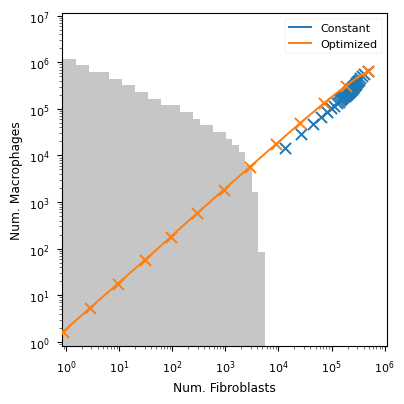

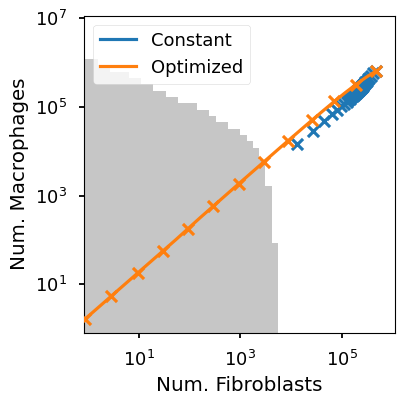

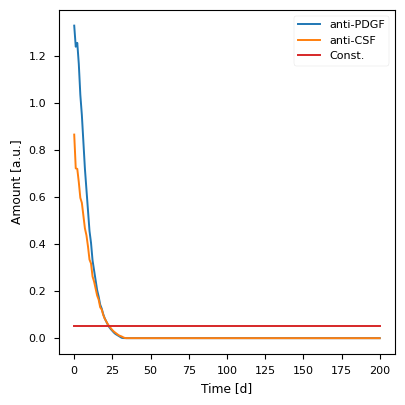

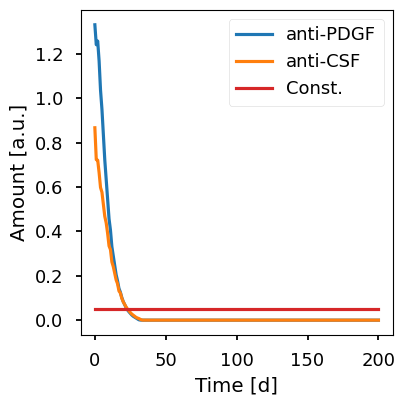

In [25]:
def plot_single_control(cs: Array, name: str = None, save_prefix: str = None):
    def plot(style_name):
        fig, ax = plt.subplots(
            1, 1, sharex=True, sharey=True, figsize=(plot_half_width, plot_half_width)
        )

        ax.set_xlabel("Time [d]")
        ax.set_ylabel("Amount [a.u.]")

        ax.plot(cs)
        #ax.axhline(0.05)
        ax.plot([0, 200], [0.05, 0.05], c="tab:red")

        ax.plot([], [], c="tab:blue", label="anti-PDGF")
        ax.plot([], [], c="tab:orange", label="anti-CSF")
        ax.plot([], [], c="tab:red", label="Const.")

        ax.legend()
        plt.tight_layout()
        show(f"/{name}_controls" + style_name, save_prefix=save_prefix)

    styles(plot)

plot_solution(
    const_sol,
    implicit_sol,
    labels=[
        "Constant",
        "Optimized",
    ],
    name="dtmax_simple",
    save_prefix="",
)

plot_single_control(implicit_cs, name="dtmax_simple", save_prefix="")